In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

In [2]:
df = pd.read_csv('sgym_ship.csv', encoding = 'Shift-JIS')
df.columns = ['date','qty']
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date").sort_index()
df.head()

,qty
date,
2018-04-04,41296.0
2018-04-05,38153.0
2018-04-06,33987.0
2018-04-07,9665.0
2018-04-08,0.0


<AxesSubplot:xlabel='date'>

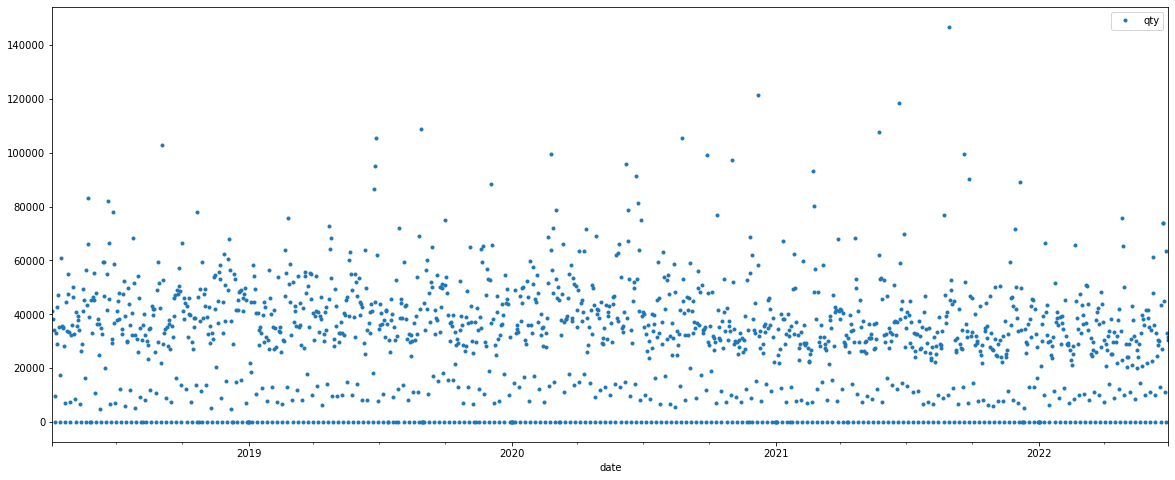

In [3]:
df.plot(style=".",figsize=(20,8), color=color_pal[0])

In [4]:
df.describe()

,qty
count,1549.000000
mean,30281.402195
std,20598.304323
min,0.000000
25%,12283.000000
50%,32534.000000
75%,42086.000000
max,146764.000000


# Analysis

In [5]:
def feature_crt(df):
    """
    Create date features using dataframe with date index
    """
    df = df.copy()
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["day"] = df.index.day
    df["dow"] = df.index.dayofweek
    df["doy"] = df.index.dayofyear
    
    return df
df_proc = feature_crt(df)

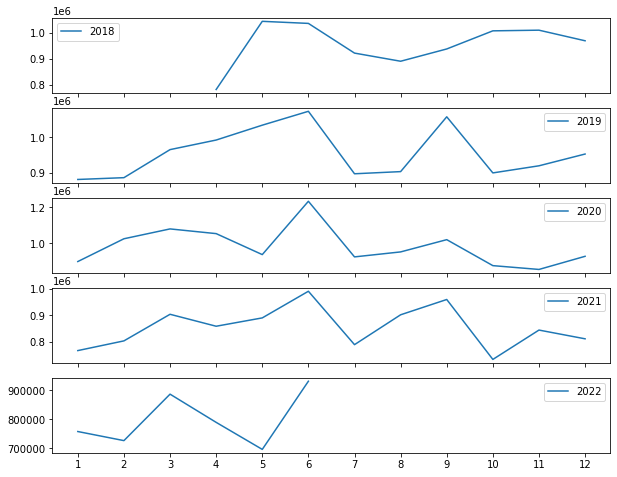

In [6]:
grouped = df_proc.groupby(["year","month"]).qty.sum()

fig, axes = plt.subplots(5,1,figsize=(10,8),sharex=True)

for ax, yr in zip(axes, df_proc["year"].unique()):
    ax.plot(grouped[yr], label=f"{yr}")
    ax.set_xticks(range(1,13))
    ax.set_xticklabels([i+1 for i in range(12)])
    ax.legend()

plt.show()

Looking at the above graph, we can see that there is a common pattern of a peak in March and June, followed by another uptick in September.

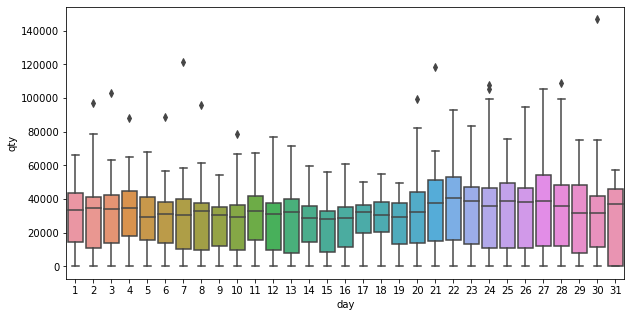

In [7]:
# group_by_day = df_proc.groupby("day").qty.mean()
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(ax=ax, data=df_proc, x="day",y="qty")
plt.show()

There seems to be a pattern of higher demand at the beginning and end of the month

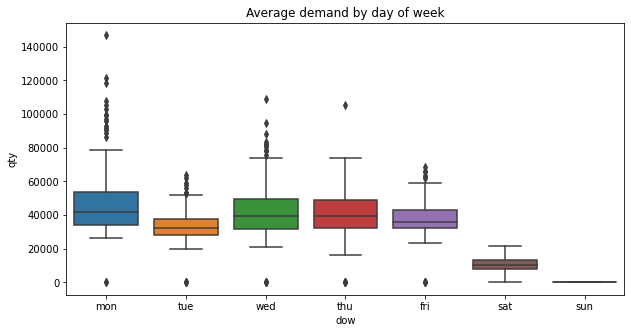

In [8]:
group_by_dow = df_proc.groupby("dow").qty.mean()

fig, ax = plt.subplots(figsize=(10,5))
# ax.plot(group_by_dow, color=color_pal[2])
sns.boxplot(ax=ax, data=df_proc, x="dow",y="qty")
ax.set_xticks(range(7))
ax.set_xticklabels(["mon","tue","wed","thu","fri","sat","sun"])
ax.set_title("Average demand by day of week")
plt.show()

Looking at average demand by day of week, we see that demand is usually highest at week beginning and lower towards the weekend

<AxesSubplot:xlabel='year,month'>

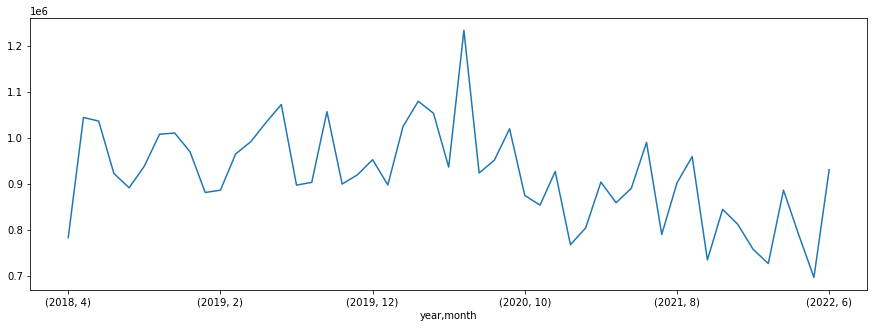

In [9]:
grouped.plot(figsize=(15,5))

# Train Test Split

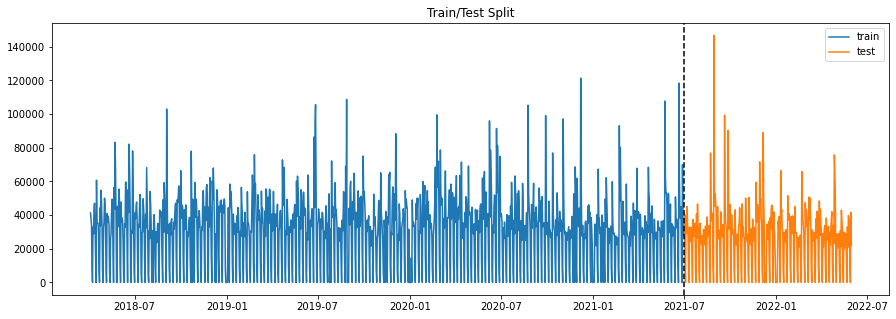

In [10]:
# Choose 1 year of data as test to cover patterns of the whole year
train = df.loc[df.index < "2021-07-01"]
test = df.loc[(df.index >= "2021-07-01") & (df.index < "2022-06-01")]
holdout = df.loc[df.index >= "2022-06-01"]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(train, label="train")
ax.plot(test, label="test")
ax.axvline(pd.to_datetime('2021-07-01'), color="black", ls="--")
ax.set_title("Train/Test Split")
plt.legend()
plt.show()

### Create features

In [11]:
train = feature_crt(train)
test = feature_crt(test)

FEATURES = ["year","month","day","dow","doy"]
TARGET = "qty"

In [12]:
X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

In [13]:
holdout = feature_crt(holdout)
X_holdout = holdout[FEATURES]
y_holdout = holdout[TARGET]

# Model Creation

In [14]:
class XGBRegressorExtended(xgb.XGBRegressor):
    """
    Custom Regressor class for forecasting values
    """
    def predict_transform(self, xtest):
        yt = self.predict(xtest)
        yt[yt<0] = 0
        return yt

In [15]:
# reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg = XGBRegressorExtended(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, y_train, 
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

[15:16:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:37357.93750	validation_1-rmse:32167.13281
[100]	validation_0-rmse:16757.06836	validation_1-rmse:13845.70019
[200]	validation_0-rmse:10418.25098	validation_1-rmse:10058.68555
[300]	validation_0-rmse:8407.15430	validation_1-rmse:9816.87500
[400]	validation_0-rmse:7468.81885	validation_1-rmse:9909.88965
[500]	validation_0-rmse:6829.69385	validation_1-rmse:9993.91113
[600]	validation_0-rmse:6349.59033	validation_1-rmse:10102.30664
[700]	validation_0-rmse:5953.83008	validation_1-rmse:10257.54688
[800]	validation_0-rmse:5626.74951	

XGBRegressorExtended(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                     colsample_bynode=1, colsample_bytree=1,
                     early_stopping_rounds=50, enable_categorical=False,
                     gamma=0, gpu_id=-1, importance_type=None,
                     interaction_constraints='', learning_rate=0.01,
                     max_delta_step=0, max_depth=6, min_child_weight=1,
                     missing=nan, monotone_constraints='()', n_estimators=1000,
                     n_jobs=8, num_parallel_tree=1, predictor='auto',
                     random_state=0, reg_alpha=0, reg_lambda=1,
                     scale_pos_weight=1, subsample=1, tree_method='exact',
                     validate_parameters=1, verbosity=None)

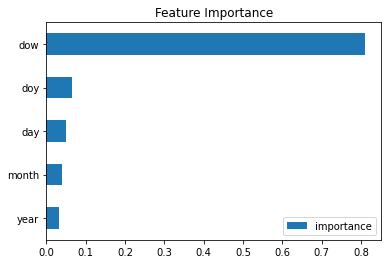

In [16]:
feat_imp = pd.DataFrame(data=reg.feature_importances_,
             index=reg.get_booster().feature_names,
             columns=['importance'])
feat_imp.sort_values('importance').plot(kind='barh', title="Feature Importance")
plt.show()

# Predict on Test

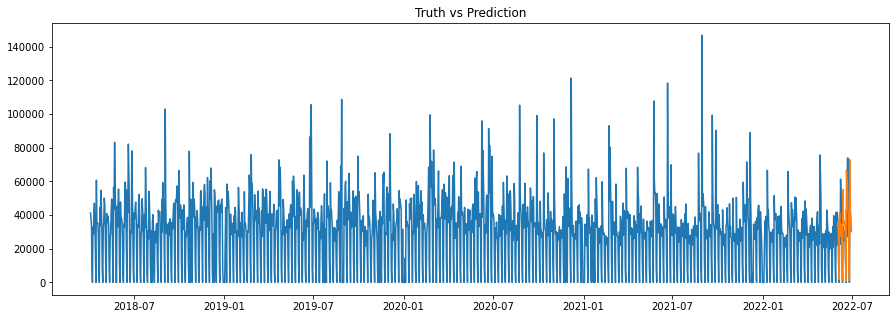

In [17]:
# test['prediction'] = reg.predict_transform(X_test)
holdout['prediction'] = reg.predict_transform(X_holdout)
# test['prediction'] = reg.predict(X_test)
if "prediction" in df_proc.columns:
    df_proc.drop("prediction")
df_proc = df_proc.merge(holdout[['prediction']], how="left",left_index=True,right_index=True) #2 brackets -> dataframe instead of series

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_proc[["qty"]], label="Truth")
ax.plot(df_proc[["prediction"]],label="Prediction")
ax.set_title("Truth vs Prediction")
plt.show()

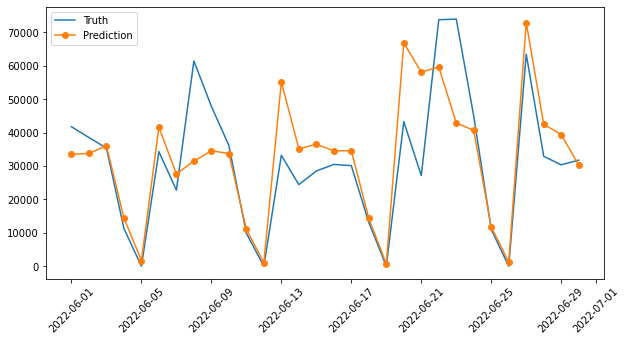

In [18]:
#Check for 1 month
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df_proc.loc[(df_proc["year"]==2022) & (df_proc["month"]==6)].qty, label="Truth")
ax.plot(df_proc.loc[(df_proc["year"]==2022) & (df_proc["month"]==6)].prediction,marker="o",label="Prediction")
plt.xticks(rotation=45)
ax.legend()
plt.show()

In [25]:
print(np.sqrt(mean_squared_error(holdout['qty'], holdout['prediction'])))
print(holdout["qty"].mean())

from sklearn.metrics import mean_absolute_error as mae
print(mae(holdout["qty"], holdout["prediction"]) / holdout["qty"].mean())


12814.025810630465
31037.2
0.2847613960331566


# Create Lag Feature

In [39]:
# How to create lag features
# Decide lag: 28 days
# Get lagged date and lagged values
df_lagged = df.copy()
df_lagged.index = df.index + pd.Timedelta(days=28)
df_lagged.rename(columns={"qty":"lag_28_d"}, inplace=True)
df.merge(df_lagged, how="left", left_index=True, right_index=True)

,qty,lag_28_d
date,,
2018-04-04,41296.0,NaN
2018-04-05,38153.0,NaN
2018-04-06,33987.0,NaN
2018-04-07,9665.0,NaN
2018-04-08,0.0,NaN
...,...,...
2022-06-26,0.0,0.0
2022-06-27,63437.0,41649.0
2022-06-28,32866.0,21982.0


# Improve with cross validation


In [20]:
def ts_split(df, fold, gap):
    
    max_idx = len(df.index)-1
    train_idx = [idx for idx in df.index if idx < df.index[max_idx-gap*(fold+1)]]
    val_idx = [idx for idx in df.index if idx >= df.index[max_idx-gap*(fold+1)] and idx <= df.index[max_idx-gap*fold]]
    
    return train_idx, val_idx


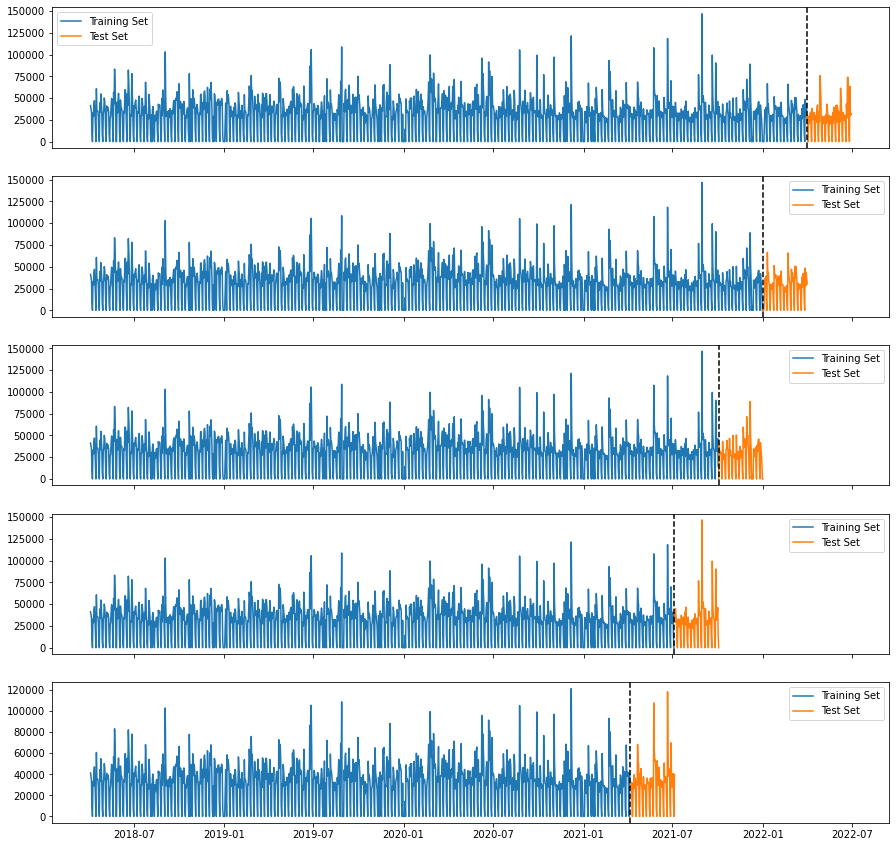

In [21]:
fig, axes = plt.subplots(5, 1, figsize=(15,15), sharex=True)
for fold in range(5):
    train_idx, val_idx = ts_split(df, fold, gap=90)
    train_1 = df.loc[train_idx]
    test_1 = df.loc[val_idx]
    axes[fold].plot(train_1, label="Training Set")
    axes[fold].plot(test_1, label="Test Set")
    axes[fold].axvline(test_1.index.min(), color="black", ls="--")
    axes[fold].legend()

plt.show()

In [22]:
for fold in range(5):
    train_idx, val_idx = ts_split(df, fold, gap=90)
    train_1 = df.loc[train_idx]
    test_1 = df.loc[val_idx]
    train_1 = feature_crt(train_1)
    test_1 = feature_crt(test_1)

    FEATURES = ["year","month","day","dow","doy"]
    TARGET = "qty"
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg_1 = XGBRegressorExtended(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
    reg_1.fit(X_train, y_train, 
           eval_set=[(X_train, y_train), (X_test, y_test)],
           verbose=100)

[15:16:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:37357.93750	validation_1-rmse:32167.13281
[100]	validation_0-rmse:16757.06836	validation_1-rmse:13845.70019
[200]	validation_0-rmse:10418.25098	validation_1-rmse:10058.68555
[300]	validation_0-rmse:8407.15430	validation_1-rmse:9816.87500
[400]	validation_0-rmse:7468.81885	validation_1-rmse:9909.88965
[500]	validation_0-rmse:6829.69385	validation_1-rmse:9993.91113
[600]	validation_0-rmse:6349.59033	validation_1-rmse:10102.30664
[700]	validation_0-rmse:5953.83008	validation_1-rmse:10257.54688
[800]	validation_0-rmse:5626.74951	

In [23]:
df_proc.head()

,qty,year,month,day,dow,doy,prediction
date,,,,,,,
2018-04-04,41296.0,2018,4,4,2,94,NaN
2018-04-05,38153.0,2018,4,5,3,95,NaN
2018-04-06,33987.0,2018,4,6,4,96,NaN
2018-04-07,9665.0,2018,4,7,5,97,NaN
2018-04-08,0.0,2018,4,8,6,98,NaN
